In [786]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torcheval.metrics

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

In [787]:
from import_data import *

In [788]:
data = import_afc_data()

100%|██████████| 8528/8528 [00:00<00:00, 10044.28it/s]


In [789]:
labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data])))}

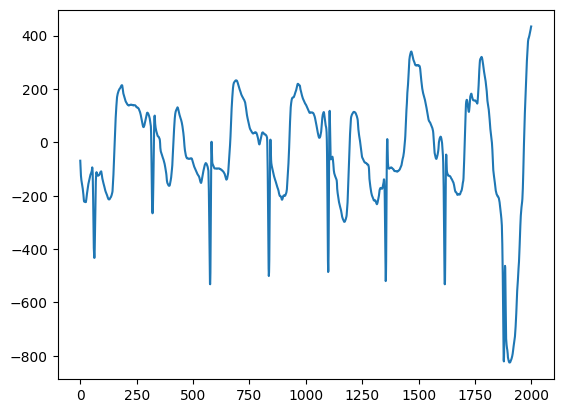

In [790]:
plt.plot(data[10][0].reshape((9000))[:2000])

In [791]:
data_train = data[:int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

In [792]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [793]:
data[0]

(array([[-127, -162, -197, ...,  -18,  -22,  -21]], dtype=int16), 'N')

In [794]:
maxes = [np.abs(x[0]).max() for x in data]

In [795]:
# plt.hist(maxes, bins=100)

In [796]:
class WindowDataset(Dataset):
    def __init__(self, data, labelmap, normalise_val=1, threshold_length=10000, device='cpu', eval=False):
        self.eval = eval

        self.maxlength = max([x[0].shape[1] for x in data])
        self.minlength = min([x[0].shape[1] for x in data])

        self.threshold_length = threshold_length

        self.data = []
        for waveform, label in data:
            self.data.append((torch.tensor(waveform.flatten() / normalise_val, dtype=torch.float32, device=device), torch.tensor(labelmap[label], device=device)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform, label = self.data[idx]

        if not self.eval:
            if waveform.shape[0] > self.minlength:
                rv = random.randint(0,waveform.shape[0]-self.minlength)
                waveform = waveform[rv:rv+self.minlength]
        else:
            if waveform.shape[0] < self.threshold_length:
                waveform = torch.cat((torch.tensor([0] * (self.threshold_length - waveform.shape[0]), device=device), waveform))
            else:
                waveform = waveform[:self.threshold_length]

        return waveform, label

In [797]:
batch_size = 64

normalise_val = np.mean([np.abs(x[0]).max() for x in data])

train_dataset = WindowDataset(data_train, labelmap, normalise_val=normalise_val, device=device)
test_dataset = WindowDataset(data_test, labelmap, normalise_val=normalise_val, device=device, eval=True)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [798]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1_layer = nn.Conv1d(1, 16, 20, 1)
        self.conv2_layer = nn.Conv2d(1, 16, 7, 1)

        self.d1 = nn.Dropout1d(0.2)
        self.d2 = nn.Dropout2d(0.2)

        self.fc_dropout = nn.Dropout(0.5)

        self.fullyconnected_layer = nn.Linear(32, 4)

    def forward(self, x):

        x = x.unsqueeze(1)
        x = self.conv1_layer(x)
        x = F.relu(x)
        x = F.max_pool1d(x, 5, 5)
        # print(x.shape)
        x = self.d1(x)
        
        x = x.unsqueeze(1)
        x = self.conv2_layer(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 5, 5)
        # print(x.shape)
        x = self.d2(x)

        x = F.avg_pool2d(x, (1, x.shape[3]))
        x = x.squeeze(3)

        x = x.view(x.shape[0], x.shape[1] * x.shape[2])
        x = self.fc_dropout(x)
        x = self.fullyconnected_layer(x)
        x = F.softmax(x, dim=1)

        return x
    
model = Model().to(device)

In [799]:
valuecounts = pd.Series([x[1] for x in data_train]).value_counts().to_dict()
totaldatapoints = sum(valuecounts.values())

In [800]:
weights = {label:totaldatapoints/x for label,x in valuecounts.items()}
weights['~'] = weights['N']

In [801]:
weights = [weights[x] for x in labelmap.keys()]

In [802]:
totaldatapoints = sum(valuecounts.values())

In [803]:
weight_tensor = torch.Tensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(model.parameters())

In [804]:
def id(labels, n):
    return torch.eye(n, device=device)[labels]

In [805]:
losses = []
accuracies = []

In [806]:
def eval(model, dataloader):
    totalloss = .0
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader, 0):
            x, label = batch

            y = id(label, n=len(labelmap))

            yhat = model.forward(x)

            loss = criterion(yhat, y)

            _, predicted = torch.max(yhat.data, 1)

            total += yhat.shape[0]
            totalloss += loss.item()
            correct += (predicted == label).sum().item()

    return totalloss / total, correct / total

eval(model, testloader)

(0.07132653027318707, 0.28722157092614303)

In [812]:
train_loss = eval(model, trainloader)
test_loss = eval(model, testloader)

losses.append((train_loss, test_loss))

for epoch in tqdm(range(100)):
    loss = 0.0

    model.train()

    for i,batch in enumerate(trainloader, 0):
        x, label = batch

        y = id(label, n=len(labelmap))

        optimizer.zero_grad()

        yhat = model.forward(x)
    
        loss = criterion(yhat, y)
        loss.backward()

        optimizer.step()

        loss += loss.item()

    train_loss = eval(model, trainloader)
    test_loss = eval(model, testloader)
    
    losses.append((train_loss, test_loss))
    # accuracies.append((train_accuracy, test_accuracy))

100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


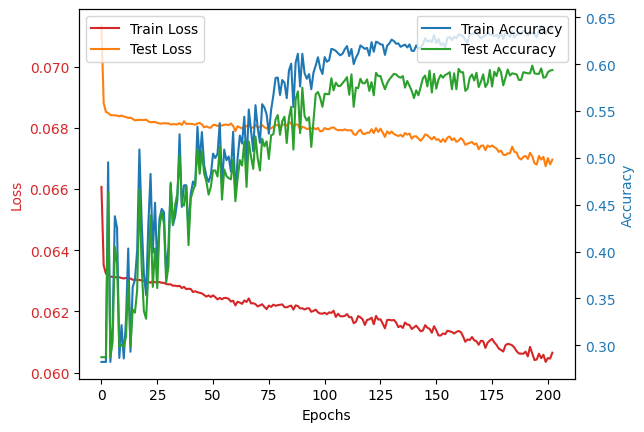

In [813]:
fig, ax1 = plt.subplots()

# Plotting 'loss' on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot([x[0][0] for x in losses], label='Train Loss', color='tab:red')
ax1.plot([x[1][0] for x in losses], label='Test Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')

# Creating a second y-axis for 'accuracy'
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot([x[0][1] for x in losses], label='Train Accuracy', color='tab:blue')
ax2.plot([x[1][1] for x in losses], label='Test Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

# Show the plot
plt.show()
